# mmap.ninja

This if a demo of `mmap_ninja`, which allows you to store your machine learning datasets in memory-mapped format during training.

This allows you to significantly speed up the I/O and accelerate the time for iteration over the dataset by up to **20 times**!

We'll demonstrate its power by converting an image segmentation dataset into
a memory-mapped format.

In [2]:
!pip install --upgrade mmap_ninja

  Attempting uninstall: mmap_ninja
    Found existing installation: mmap-ninja 0.5.3
    Uninstalling mmap-ninja-0.5.3:
      Successfully uninstalled mmap-ninja-0.5.3


In [3]:
# Download the dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz


--2023-12-29 07:06:53--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-12-29 07:06:54--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-12-29 07:06:54--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

In [4]:
# Extract images
!tar -xf images.tar.gz

In [5]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from os import listdir
from pathlib import Path
from tqdm import tqdm
from time import time

Let's have a quick a look at the dataset first.

The dataset consists of a directory of images in `jpg` format.

Number of images: 7390


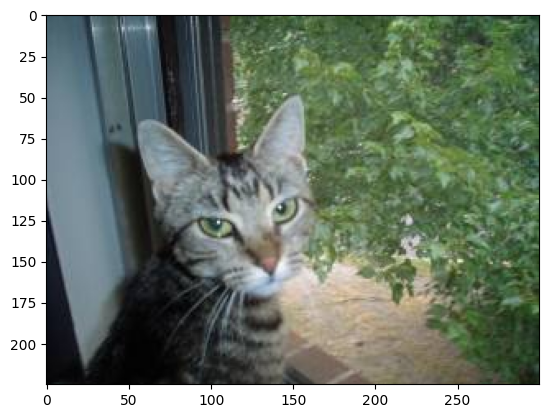

In [6]:
input_dir = Path("images")

img_paths = [path for path in input_dir.iterdir() if path.suffix == '.jpg']
print(f'Number of images: {len(img_paths)}')
path_to_some_image = img_paths[1]
img = mpimg.imread(path_to_some_image)
plt.imshow(img)

In [7]:
img.shape

(225, 300, 3)

Let's check how long does it take to make one iteration over the dataset of just reading the image.

This time will be added to the total training time of every epoch, so we should
make this as fast as possible.

In [8]:
start_t = time()
for img_path in tqdm(img_paths):
  img = mpimg.imread(img_path)
total_t = time() - start_t
print(f'\nTime for iteration (s): {total_t}')

100%|██████████| 7390/7390 [00:26<00:00, 283.12it/s]


Time for iteration (s): 26.11518692970276


Now, let's convert the dataset into a `RaggedMmap`! It is called `Ragged`, because it can handle a dataset with different shapes, or even with different number of axes (e.g. you can mix grayscale images with RGB images)!

The first step is to convert the images into a `RaggedMmap`.

This is done only once for the whole project, because it is persisted.

In [9]:

from mmap_ninja.ragged import RaggedMmap


In [10]:

RaggedMmap.from_generator(
    out_dir='images_mmap',
    sample_generator=map(mpimg.imread, img_paths),
    batch_size=1024,
    verbose=True
)


7390it [00:47, 155.12it/s]


<mmap_ninja.ragged.RaggedMmap object at 0x7e952cef3bb0> of length: 7390

Now let's open the memory map and show an image

Number of images in memory map: 7390


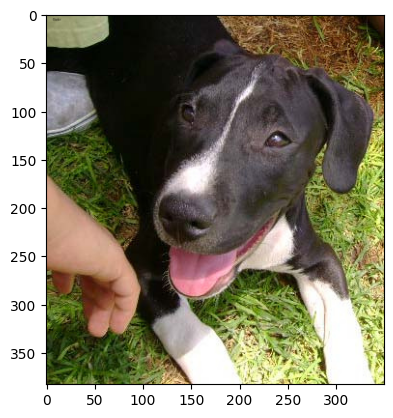

In [11]:
images_mmap = RaggedMmap('images_mmap')

print(f'Number of images in memory map: {len(images_mmap)}')
plt.imshow(images_mmap[0])

In [13]:
start_t = time()
for i in tqdm(range(len(images_mmap))):
  img = images_mmap[i]
total_mmap_t = time() - start_t
print(f'\nTime for iteration (s): {total_mmap_t}')

100%|██████████| 7390/7390 [00:00<00:00, 48641.25it/s]


Time for iteration (s): 0.15601253509521484


In [14]:
start_t = time()
for i in tqdm(np.random.randint(len(images_mmap), size=len(images_mmap))):
  img = images_mmap[i]
total_mmap_t = time() - start_t
print(f'\nTime for iteration (s): {total_mmap_t}')

100%|██████████| 7390/7390 [00:00<00:00, 41408.37it/s]


Time for iteration (s): 0.19269633293151855


In [15]:
ratio = total_t / total_mmap_t
print(f'We can see that the mmap_ninja is {ratio:.2f} times faster than storing the images as jpegs on the disk!')

We can see that the mmap_ninja is 135.53 times faster than storing the images as jpegs on the disk!


We've seen a dramatic improvement in the time for one iteration over the dataset.

It makes a big difference whether you are going to wait for one minute or one
second!

Especially since this has to be done for every epoch, and every model you want
to experiment with, this quickly adds up!

**Quick tip**: If you want to apply a function when a given sample is loaded into memory, use the `wrapper_fn` argument.

For example, if you want `images_mmap[0]` to be returned as a PyTorch tensor:

In [16]:
import torch
torch_mmap = RaggedMmap('images_mmap', wrapper_fn=torch.tensor)

In [17]:
torch_mmap[0]


tensor([[[152, 155, 110],
         [151, 154, 111],
         [149, 152, 109],
         ...,
         [ 87,  44,  25],
         [ 83,  45,  24],
         [ 80,  44,  22]],

        [[148, 151, 108],
         [148, 151, 108],
         [148, 151, 108],
         ...,
         [ 87,  44,  25],
         [ 84,  46,  25],
         [ 81,  44,  25]],

        [[144, 147, 104],
         [147, 150, 107],
         [144, 147, 104],
         ...,
         [ 88,  45,  26],
         [ 86,  48,  29],
         [ 82,  47,  27]],

        ...,

        [[ 59,  55,  20],
         [ 53,  52,  21],
         [ 34,  37,  10],
         ...,
         [240, 247, 167],
         [179, 187, 114],
         [141, 149,  76]],

        [[ 74,  71,  38],
         [ 58,  59,  25],
         [ 42,  48,  10],
         ...,
         [180, 192,  90],
         [128, 139,  47],
         [131, 141,  54]],

        [[ 72,  72,  36],
         [ 67,  69,  30],
         [ 59,  68,  21],
         ...,
         [199, 213, 100],
        

**Another tip**: You can `append` or `extend` the `RaggedMmap`, in the same way you could with regular Python `list`s!

In [ ]:
print(len(images_mmap))

7390


In [ ]:
images_mmap.append(img)

In [ ]:
print(len(images_mmap))

7391


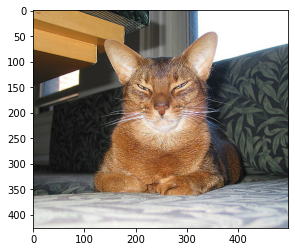

In [ ]:
plt.imshow(images_mmap[-1])

**Another tip**: To add multiple images to the memory map, just pass them as a list of numpy arrays to the `.extend` method:


In [ ]:
images_mmap.extend([img, img])

In [ ]:
len(images_mmap)

7394

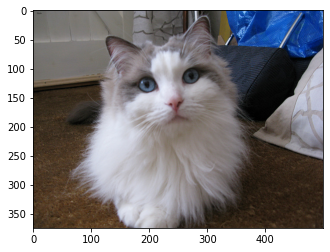

In [ ]:
plt.imshow(images_mmap[-1])